# Country & Soul
### *Analyzing Trends in American Music Journalism from 1960 to Present*
---

# Textual Analysis 
#### Table of Contents
1. [Introduction](#introduction)
    1. [Add Metadata Features](#subparagraph1)
2. [Vector Space Modeling](#paragraph1)
    1. [Doc-Term Matrix](#subparagraph2)
    2. [Time-Term Matrix](#subparagraph3)
3. [Clustering](#paragraph2)
    1. [Dendrogram Representation](#subparagraph4)
    2. [t-SNE Representation](#subparagraph5)
4. [Principal Component Analysis](#paragraph3)
5. [Topic Modeling](#paragraph4)
    1. [Corpus Level Topics](#subparagraph6)
    2. [Genre Level Topics](#subparagraph7)
6. [Word Embeddings](#paragraph5)
7. [Sentiment Analysis](#paragraph6)
    1. [NRC Lexicon](#subparagraph8)
    2. [VADER Ananlysis](#subparagraph9)

## Introduction<a name="introduction"></a>
In this notebook, I apply several analytical techniques to the corpus of music reviews. I employ vector space models (VSM), clustering methods, Principal Component Analysis (PCA), topic models, word embeddings, and semantic analysis.

To begin, I read in the tables that I created in *`Digital Analytical Edition.ipynb`*.

In [1]:
# Libraries
import pandas as pd
import numpy as np
import plotly.express as px


from itertools import chain
from sklearn.neighbors import KernelDensity as KDE
from gensim.models import word2vec
from ast import literal_eval

import plotly.io as pio
pio.renderers.default='notebook'

In [2]:
# define OHCO structure
OHCO = ['article_id', 'para_id', 'sent_id', 'token_id']

# import data
path = "./data/"

LIB = pd.read_csv(path+"LIB.csv")
LIB.set_index('article_id', inplace = True)
LIB.subjects = LIB.subjects.apply(literal_eval)
LIB.date = pd.to_datetime(LIB['date']).dt.date

# add label column for plots
LIB['label'] = LIB.apply(lambda x: f"{x.topic}: {x.subjects[0]}, {x.date}", 1)

VOCAB = pd.read_csv(path+"VOCAB.csv")
VOCAB.set_index('term_str', inplace = True)

CORPUS = pd.read_csv(path+"CORPUS.csv")
CORPUS.set_index(OHCO, inplace = True)

In [3]:
uBOW = pd.read_csv(path+"BOW_unigrams.csv")
uBOW.set_index(['article_id', 'term_str'], inplace = True)

nBOW = pd.read_csv(path+"BOW_ngrams.csv")
nBOW.set_index(['article_id', 'term_str'], inplace=True)

#### Add Features to Metadata<a name="subparagraph1"></a>
I add some features to the `LIB` table to aid with vizualization. I add a column that identifies the most popular artists in the corpus. I also add a column which identifies the most common publications. Finally, I add a column which records the difference in days of the current publication and the first publication in the corpus.

In [4]:
# Frequent artists by genre
soul_artists = list(chain.from_iterable(LIB[LIB.topic == 'soul'].subjects))
country_artists = list(chain.from_iterable(LIB[LIB.topic == 'country'].subjects))

top_soul_artists  = pd.DataFrame(soul_artists).value_counts().to_frame().head(5)
top_soul_artists.index.names = ['artist']
top_soul_artists.rename(columns = {0:'mentions'}, inplace = True)

top_country_artists = pd.DataFrame(country_artists).value_counts().to_frame().head(5)
top_country_artists.index.names = ['artist']
top_country_artists.rename(columns = {0:'mentions'}, inplace = True)

top_artists = pd.concat([top_soul_artists, top_country_artists])
top_artists = top_artists.reset_index().artist.to_list()
top_artist_bool = [any(i in x for i in top_artists) for x in LIB.subjects]

top_artist_list = [[i for i in top_artists if i in x] for x in LIB.subjects]
top_artist_label = ['-'.join(x) if x != [] else np.nan for x in top_artist_list]

LIB['top_artist'] = top_artist_label

In [5]:
# Flag top 10 publications
top_publications = LIB.source.value_counts().head(10).index.to_list()

LIB['top_publication'] = [x if x in top_publications else np.nan for x in LIB.source]

In [6]:
LIB = LIB.sort_values(by='date')

start_date = LIB.iloc[0].date

LIB['days_since'] = (LIB.date-start_date)
LIB.days_since= LIB.days_since.astype('str').str.split()
LIB.days_since = [float(x[0]) for x in LIB.days_since]

---
## Vector Space Modeling<a name="paragraph1"></a>

Here, I create several vector space models (VSMs). The first VSM is a straightforward document-term matrix. This representation allows me to asses the similarity of documents in the corpus.

The second VSM is a term-time matrix that measures term occurence over time. Terms are assigned a time step based on the order of their occurence in an article. Publication dates are used to order articles within the corpus.

#### Doc-Term Matrix<a name="subparagraph2"></a>

In [7]:
# Creating the Doc-Term Matrix
DTM = uBOW.tfidf.unstack('term_str', 0)
DTM.columns = DTM.columns.astype(str)

In [8]:
from sklearn.decomposition import PCA

pca_engine = PCA(n_components = 5)

docPCs = pca_engine.fit_transform(DTM)
DOCTERMPC = pd.DataFrame(docPCs, index = DTM.index, columns = ['PC1', 'PC2', 'PC3', 'PC4', 'PC5'])
DOCTERMPC = DOCTERMPC.join(LIB)

In [9]:
px.scatter(DOCTERMPC,
           x = 'PC1',
           y = 'PC2',
           color = 'topic',
           width=800,
           hover_name = DOCTERMPC.index,
           title = 'Fig. 1 Genre')

In [10]:
ARTIST_DOCTERMPC = DOCTERMPC.loc[DOCTERMPC.top_artist.notna()]
px.scatter(ARTIST_DOCTERMPC,
           x = 'PC2',
           y = 'PC3',
           width=800,
           color = 'top_artist',
           hover_name = ARTIST_DOCTERMPC.index,
           title = 'Fig. 2 Top Artists')

In [11]:
PUBLICATION_DOCTERMPC = DOCTERMPC.loc[DOCTERMPC.top_publication.notna()]
px.scatter(PUBLICATION_DOCTERMPC,
           x = 'PC1',
           y = 'PC4',
           width=800,
           color = 'top_publication',
           hover_name = PUBLICATION_DOCTERMPC.index,
           title = 'Fig. 3 Top Publications')

In [12]:
px.scatter(DOCTERMPC,
          x = 'PC2',
          y = 'PC3',
          width = 800,
          color = 'days_since',
          color_continuous_scale='spectral',
          hover_name = DOCTERMPC.index,
          hover_data = ['subjects'],
          title = 'Fig. 4 Publication Dates',
          labels = {'days_since' : 'Days since 1st Publication'})

**Analysis**  
After creating a document-term matrix representation of the corpus, I projected the documents onto the first five principal components. I plotted the five PCs against each other and looked for clusters of genre, artist, publication, and date.

**Figure 1** shows a striking separation by genre along the second PC. Although it would be improper to attribute meaning to the PCs, it seems like the second PC measures genre-specific language and captures the opposition between country music articles and soul music articles.

**Figure 2** looks at a subset of articles in the corpus. Only articles that discuss the top five soul musicians or top five country musicians are plotted along the second and third PCs. Here, there is some clustering by artist. Articles discussing Prince separate themselves along the third PC. There are also distinc clusters for Stevie Wonder, James Brown, and Aretha Franklin. Interestingly, these are all soul artists. This could suggest that language used to describe soul musicians is more distinctive than the language used for country musicians. Or, this could simply be an artifact caused by including four times as many soul articles as country articles in the corpus. In either case, the second and third PCs seem to distinguish articles by artist.

**Figure 3** investigates the most common journals in the corpus. I hypothesized that the articles published by the same source would cluster together. This might suggest that different publications used unique stylistic features in their music journalism. Clearly there are no clusters or discernible patterns in the figure. This could indicate that the top 10 publications are not stylistically different, or that stylistic features are not particularly significant when examining document similarity.

**Figure 4** attempts to show temporal patterns. There seems to be a gradiation of older articles to newer articles along the second PC. Although the trend is a little fuzzy, it is sharp enough to assume that there was a shift in the language used in music journalism over the period of study.

#### Time-Term Matrix<a name=subparagraph3></a>
First, I represent the corpus with a Time-Term matrix. Often, time-term matrices relate the instances of a term to it's position in a document. Since the documents in this corpus are relatively short, I am more interested in word occurence over the length of corpus. I create two matrices. The first, `CALENDAR_TIME`, records n-gram occurence over actual calendar dates. Suppose an n-gram occurs in an article at least once. Then, `CALENDAR_TIME` would record a '1' for that n-gram on the article's publication date. If an n-gram does not occur in any articles on that date, a '0' is recorded.

Unfortunately, the publication dates of articles in the corpus are not uniformly distributed. N-grams may display artificially high frequency in time periods with many articles. I attemp to mitigate this with the second matrix, `CORPUS_TIME`. This matrix is essentially the same as `CALENDAR_TIME`, except it does not factor in publications dates. Instead, it records n-gram occurence based on the sequence of articles in the corpus. For example, if a given n-gram occurs in the third article in the corpus, a '1' would be recorded for the n-gram at time-step 3. 

I unstack the `nBOW` to create each matrix. `nBOW` contains the 20,000 most frequent n-grams in the corpus, instead of just unigram terms. This choice was made so that full artist names, like *Aretha Franklin*, can be compared.

In [13]:
# creating calendar_time
CALENDAR_TIME = nBOW.n.unstack('term_str', 0).join(LIB.days_since).groupby('days_since').sum()

# if n-gram occurs at least once, record a 1
CALENDAR_TIME[CALENDAR_TIME != 0] = 1

new_index = pd.Index(np.arange(0,max(CALENDAR_TIME.index)+1), name='days_since')
CALENDAR_TIME = CALENDAR_TIME.reindex(new_index).fillna(0)

CALENDAR_TIME = CALENDAR_TIME.T
CALENDAR_TIME.index.name = 'term_str'
CALENDAR_TIME = CALENDAR_TIME.rename_axis(columns = None)

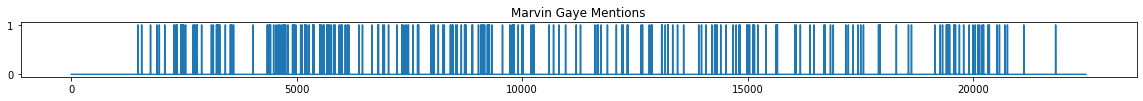

In [14]:
# sample dispersion plots over calendar time
# horizontal axis: number of days since publication of first article in corpus (January 1960)

cfg = {'figsize': (20,1),
      'title':"Marvin Gaye Mentions"}
CALENDAR_TIME.loc['marvin gaye'].plot(**cfg);

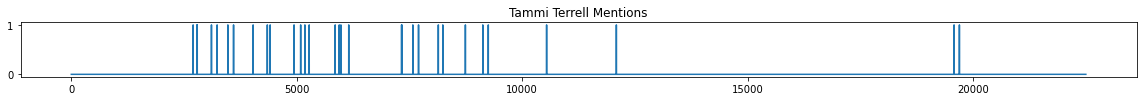

In [15]:
cfg = {'figsize': (20,1),
      'title':"Tammi Terrell Mentions"}
CALENDAR_TIME.loc['tammi terrell'].plot(**cfg);

In [16]:
# create CORPUS_TIME
CORPUS_TIME = nBOW.n.unstack('term_str', 0).join(LIB.days_since).groupby('days_since').sum()
CORPUS_TIME[CORPUS_TIME != 0] = 1
CORPUS_TIME = CORPUS_TIME.reset_index().drop(columns ='days_since').T
CORPUS_TIME.index.name = 'term_str'

I create two functions for vizualiazing Kernel Density Estimates (KDE. 
+ `compute_kde` - Accepts a time-term matrix, term, and KDE parameters. Computes KDE for given term
+ `plot_kde` - Accepts results of `compute_kde` as a dataframe. Create KDE line plot for each term supplied.

In [17]:
def compute_kde(TTM, term, bandwidth = 200, grid = 1000, dates = False ):
    import datetime
    import matplotlib.pyplot as plt
    scale_max = max(TTM.columns)
    
    term_series = TTM.loc[term]
    term_arr = np.array(term_series.drop(term_series[term_series==0].index).index)[:, np.newaxis]

    x_axis = np.linspace(0, scale_max, grid)[:, np.newaxis]
    kde =  KDE(kernel='gaussian', bandwidth = bandwidth).fit(term_arr)
    score = kde.score_samples(x_axis)
    dens = np.exp(score)*(scale_max/grid)
    
    if dates:
        start_date = datetime.date(year=1960, month=1, day=1)
        dates = [start_date+datetime.timedelta(days=i[0]) for i in x_axis]
        
        #plt.plot(dates, dens)
        return pd.DataFrame([(dates, dens)], columns = ['date', 'density'], index = [term])
    
    #plt.plot(x_axis, dens)
    #fig = px.line(x_axis, dens)
    #fig.show()
    return pd.DataFrame([(x_axis, dens)], columns = ['x', 'density'], index = [term])


In [18]:
def plot_kde(kde_results):
    term_list = [x for x in kde_results.index]
    axis_name = kde_results.columns[0]
    
    if axis_name == 'x':
        title = 'KDE Term Distribution over Corpus Time'
    else:
        title = 'KDE: Term Distribution over Calendar Time'
    
    axis_df = pd.DataFrame(kde_results.iloc[0][axis_name], columns = [axis_name])
    density_df = kde_results.density.to_frame().T.explode(term_list).reset_index(drop=True)
    plot_df = axis_df.join(density_df)
    
    fig = px.line(plot_df, 
                  x=axis_name, 
                  y = term_list,
                  title = title,
                  width = 700,
                  height = 300,
                  color_discrete_sequence=px.colors.qualitative.D3,
                  labels = {'value':'density',
                            'variable':'term'}).update_layout(legend=dict(orientation="h"))
    fig.show()

In [19]:
# Fig 5. Banjo
banjo_params  = {'TTM':CALENDAR_TIME,
                'term':'banjo',
                'bandwidth':500,
                'grid':500,
                'dates':True}

plot_kde(compute_kde(**banjo_params))

In [20]:
# Fig. 6 
audio_formats  = ['vinyl', 'cassette', 'cd', 'digital']
audio_results = pd.concat([compute_kde(CALENDAR_TIME, x, 1000, 500, True) for x in audio_formats])
plot_kde(audio_results)

In [21]:
# fig 7. Artists over Calendar Time
country_artists=['loretta lynn', 'dolly parton', 'trisha yearwood', 'taylor swift']
artist_results = pd.concat([compute_kde(CALENDAR_TIME, x, 1000, 200, True) for x in country_artists])
plot_kde(artist_results)

In [22]:
# fig 8. Artists over Calendar Time
country_artists=['loretta lynn', 'dolly parton', 'trisha yearwood', 'taylor swift']
artist_results = pd.concat([compute_kde(CORPUS_TIME, x, 100, 200) for x in country_artists])
plot_kde(artist_results)

In [23]:
# # Fig 9. & Fig 10. Going Solo
solo_artist=['supremes', 'diana ross']
solo_results = pd.concat([compute_kde(CALENDAR_TIME, x, 700, 200, True) for x in solo_artist])
plot_kde(solo_results)

solo_artist=['fugees', 'lauryn hill']
solo_results = pd.concat([compute_kde(CALENDAR_TIME, x, 700, 200, True) for x in solo_artist])
plot_kde(solo_results)

**Analysis**

**Fig. 5** visualizes the KDE for significance of term *banjo* over calendar time. This plot is primarily a proof of concept, but this double-peaked plot is interesting in itself. It suggests that the term *banjo*, was most significant in the mid 1970s before seeing a resurgence in the 2000s. 

**Fig. 6** investigates the significance of different audio formats over corpus time. *Vinyl* appears somewhat consistently throughout the corpus, whereass *cassette* and *cd* exhibit a prominent rise and fall.

**Fig. 7** attempts to show this method can be used to measure an artists career. I compared four well-known country musicians who achieved peak notoriety in different eras. The plot shows that *Trisha Yearwood* has much higher peak significance within the corpus than *Dolly Parton* and *Loretta Lynn*. This is counter to my intuition. This plot says less about the indvidual careers of the artists and more about the nature of celebrity over time.

**Fig. 8** draws contrast with Figure 7 by plotting the same country artists over corpus time. The plots are qualitatively very similar. This could mean that an uneven distribution of articles over time may not be a detrimental as initially thought.

**Fig. 9 & Fig. 10** show artists who left their bands to go solo. Fig. 9 could suggest that Diana Ross was able to extend her significance in the media by going solo. It is worth noting that this corpus is likely inappropriate for comparing the significance of The Supremes and Diana Ross in music journalism. Most would argue that Diana Ross was affiliated with Disco more than Soul and R&B in her individual career. Thus, she is not well represented in the corpus. It is easier to claim that The Supremes are classified as a soul group. Still, a more expansive corpus would certainly improve this analysis.

Fig. 10 shows that Lauryn Hill's individual significance parallels the Fugees. I hypothesize that journalists may often refer to the fugees when writing about lauryn hill as a way of contextualizing her career. 

---
## Clustering<a name="paragraph2"></a>
#### Dendrogram Representation<a name=subparagraph4></a>
I apply hierarchical agglomerative clustering at the document level to identify more patterns. As an initial step, I reduce the vocabulary since agglomerative clustering is computationally expensive. From the N-gram bag-of-words table, I select the top 10% open-category terms by mean tfidf.

In [24]:
from sklearn.cluster import AgglomerativeClustering as AC

In [25]:
# filter VOCAB
open_pos = "NN NNS VB VBD VBG VBN VBP VBZ JJ JJR JJS RB RBR RBS".split()

reduced_index = (VOCAB.max_pos.isin(open_pos)) & (VOCAB.tfidf_mean > VOCAB.tfidf_mean.quantile(0.9))
reduced_VOCAB = VOCAB[reduced_index]

# create DOCTERM TFIDF matrix
TFIDF = uBOW.tfidf.unstack(fill_value=0)

# determine which terms are in TFIDF and reduced_VOCAB
tfidf_terms = set(TFIDF.columns)
red_vocab_terms = set(reduced_VOCAB.index)
common_terms = list(tfidf_terms.intersection(red_vocab_terms))


# filter TFIDF with reduced_VOCAB
TFIDF = TFIDF[common_terms]

In [26]:
TFIDF = TFIDF.loc[TFIDF.index.str.contains('c')] # only country music articles

Next, I apply hierarchical agglomerative clustering.

In [27]:
clustering = AC(n_clusters=2).fit(TFIDF)

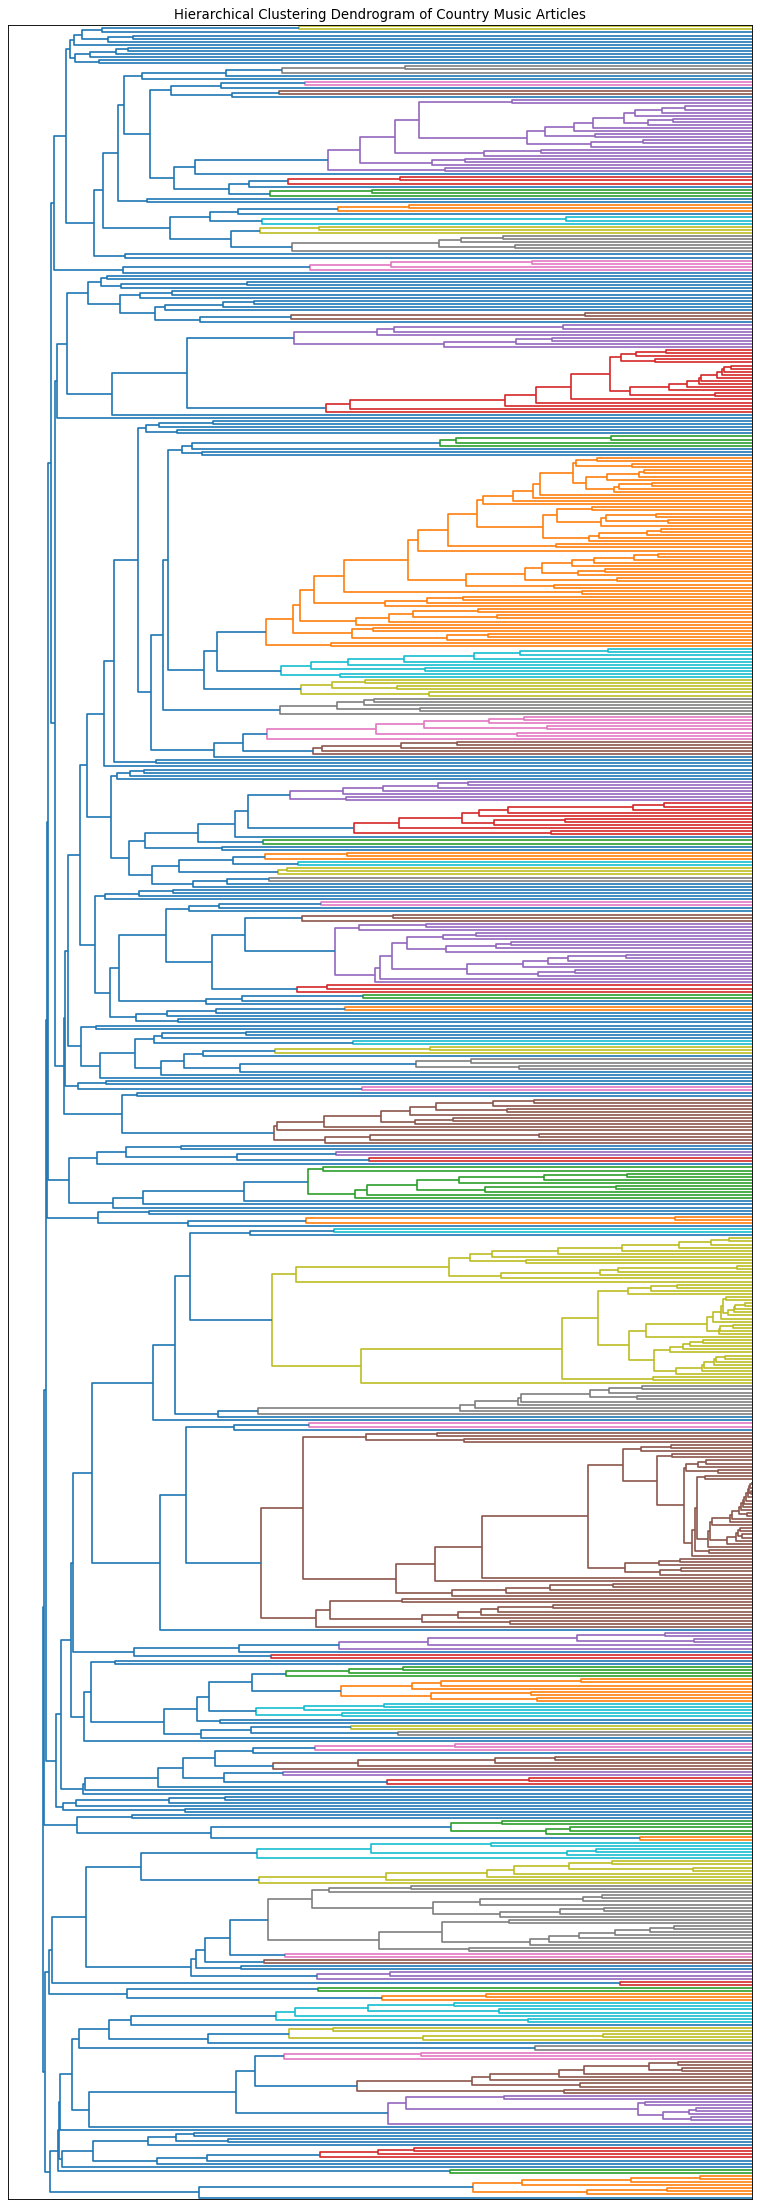

In [28]:
import numpy as np

from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram
from sklearn.datasets import load_iris
from sklearn.cluster import AgglomerativeClustering

def plot_dendrogram(model, **kwargs):

    # Children of hierarchical clustering
    children = model.children_

    # Distances between each pair of children
    # Since we don't have this information, we can use a uniform one for plotting
    distance = np.arange(children.shape[0])

    # The number of observations contained in each cluster level
    no_of_observations = np.arange(2, children.shape[0]+2)

    # Create linkage matrix and then plot the dendrogram
    linkage_matrix = np.column_stack([children, distance, no_of_observations]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, orientation="left", **kwargs)



plt.figure(figsize=(12, 36), dpi=80)
ax = plt.gca()
ax.axes.xaxis.set_visible(False)
ax.axes.yaxis.set_visible(False)
plt.title('Hierarchical Clustering Dendrogram of Country Music Articles')

myplot = plot_dendrogram(clustering)


Clearly, there are too many documents to benefit from a dendrogram. A t-SNE representation may be more useful. 

#### t-SNE Representation<a name=subparagraph5></a>

In [29]:
from sklearn.manifold import TSNE


exclude = ['s14908', 'c516', 's7610', 's5612', 'c2010', 's15309']
TFIDF = nBOW.tfidf.unstack(fill_value=0)
TFIDF = TFIDF.drop(exclude)

tsne_params = dict(
    learning_rate = 200., #'auto' or [10.0, 1000.0]
    perplexity = 30,
    n_components = 3,
    init = 'random',
    n_iter = 1000,
    random_state = 23    
)

tsne_engine = TSNE(**tsne_params)
tsne_model = tsne_engine.fit_transform(TFIDF)

COORDS = pd.DataFrame(tsne_model, columns=['x','y','z'], index=TFIDF.index)\
    .join(LIB, how='left')
COORDS = COORDS.fillna('blank')
COORDS = COORDS.loc[COORDS.top_artist.isin(top_artists)]

In [30]:
px.scatter_3d(COORDS.reset_index(), 
           'x', 'y','z', 
           color='top_artist', 
           hover_name='top_artist',           
           height=1000, width=1000).update_traces(
                mode='markers+text', 
                textfont=dict(color='black', size=14, family='Arial'),
                textposition='top center')

t-SNE does an excellent job of clustering articles by artist. While this leads to a lovely visualization, it's not exactly insightful. It's likely t-SNE recognizes that artist and band names are the most discriminating terms in the corpus. This clustering surfaces information that could be otherwised learned by scraping the article titles.

*Not pictured here,* I performed clustering on articles with proper nouns removed. Articles no longer clustered by artist. In fact, there was no discernible patterns to clusters.

---
## Principal Component Analysis<a name="paragraph3"></a>

I previously used PCA to investigate clustering patterns at the article level. In this section, I will formally construct two tables that record principal components and loadings. The first table, `DCM`, is a Document-Component Matrix where each row represents a document and each column is a principal component. The second table is `LOADINGS` which records the loading vectors for the principal components. Each row is a loading vector for a specified term. 

As a first step, I create a dataframe of normalized TFIDF values. To create the TFIDF dataframe, I unstack the unigram bag-of-words. Note that this bag-of-words has stopwords removed and TFIDF values are already normalized.

In [31]:
uTFIDF = uBOW.tfidf.unstack('term_str', 0)
uTFIDF.columns = uTFIDF.columns.astype(str)
uTFIDF = uTFIDF.drop('nan', axis=1)

# select top 10 terms by mean tfidf
top_terms = VOCAB.loc[uTFIDF.columns].sort_values(by='tfidf_mean', ascending = False).head(10000).index
uTFIDF = uTFIDF[top_terms]

In [32]:
# initialize PCA engine
pca_engine = PCA(n_components = 12)

# compute top 20 PCs
DCM = pd.DataFrame(pca_engine.fit_transform(uTFIDF), columns = list(range(0,12)), index = uTFIDF.index)
DCM.columns.name = 'PC'

In [33]:
# get loadings
LOADINGS=pd.DataFrame(pca_engine.components_, columns = uTFIDF.columns, index = list(range(0,12))).T

In [34]:
LOADINGS.sample(5)

0         1         2         3         4         5   \
term_str                                                               
tugging  -0.001437  0.001198 -0.000300 -0.000908 -0.002399  0.004152   
raised    0.006856  0.005539  0.001354  0.003370 -0.004170  0.004191   
photos    0.002339 -0.001371  0.001647 -0.003691 -0.000048 -0.000722   
huffs    -0.001208 -0.002968 -0.003275  0.000713 -0.000326  0.000682   
player    0.017892  0.002949  0.006898  0.038376 -0.003319 -0.023530   

                6         7         8         9         10        11  
term_str                                                              
tugging   0.000906 -0.003222 -0.002141  0.003106  0.002745 -0.002226  
raised    0.002303 -0.002652  0.008567  0.002165 -0.001340  0.012150  
photos   -0.000650  0.002099  0.005325 -0.000999  0.001342  0.002101  
huffs    -0.005284 -0.002198  0.003973 -0.000550  0.008240 -0.002581  
player   -0.009058  0.026829 -0.022714 -0.015322 -0.001745  0.001175

Earlier in this notebook, I investigated the corpus along the first 5 principal components. I attached metadata features and attempted to identify clusters. For the sake of brevity, I do not create additional PCA plots here. Instead, I plot the loadings and hypothesis how terms in the corpus are related to the principal components.

In [35]:
# attach VOCAB features to loadings table
LOADINGS_plot = LOADINGS.join(VOCAB, how='left')

# scatter plot of LOADINGS
# PC0 vs PC1
px.scatter(LOADINGS_plot.reset_index(),
           x=0, y=1,
           marginal_x='box', marginal_y='box',
           hover_name='term_str',
           hover_data=['max_pos'],
           color='max_pos_group').update_traces(marker={'size':7})

In [36]:
#PC2 vs PC3
px.scatter(LOADINGS_plot.reset_index(),
           x=2, y=3,
           hover_name='term_str',
           hover_data=['max_pos', 'n'],
           height=800, width=800,
           color='max_pos_group').update_traces(marker={'size':10})\
                                 .update_layout(legend=dict(orientation="h"))

The loadings plots don't reveal any obvious global patterns. There are some local groupings of similar words. For instance 'johnny', 'cash', 'willie', and 'nelson' can all be found near each other. This could mean that the loadings capture some semantic information, but this is a tough case to argue.

I write the `DCM` and `LOADINGS` tables to csv files for later use.

In [37]:
# write to csv
DCM.to_csv("./data/DCM.csv")
LOADINGS.to_csv("./data/LOADINGS.csv")

---
## Topic Modeling<a name="paragraph4"></a>

I perform topic modeling on the corpus to uncover latent topics. I use scikit-learn's Latent Dirichlet Allocation implementation as the topic modeling method. Two tables, `THETA` and `PHI`, capture the document-topic matrix and topic-term matrix respectively.

#### Corpus Level Topics<a name=subparagraph6></a>

In [38]:
from sklearn.decomposition import LatentDirichletAllocation as LDA

# create doc-term count matrix for LDA
X = uBOW.n.unstack(fill_value=0)
X.columns = X.columns.astype(str)
X = X.drop('nan', axis=1)
X = X[top_terms]

# initialize lda_engine
n_topics = 20
max_iter = 20
offset = 50

lda_engine = LDA(n_components=n_topics, max_iter=max_iter, learning_offset=offset, random_state=0)

# create THETA
THETA = pd.DataFrame(lda_engine.fit_transform(X), index = X.index)
THETA.columns.name = 'topic_id'

# create PHI
PHI = pd.DataFrame(lda_engine.components_, columns=X.columns)
PHI.index.name = 'topic_id'
PHI.columns.name  = 'term_str'
PHI = PHI.T

In [39]:
# create TOPIC table that identifies topic ids by top terms
TOPIC = PHI.sum().to_frame('phi_sum')

PHI_P = (PHI / PHI.sum())
PHI_I = np.log2(1/PHI_P)
TOPIC['h'] = round((PHI_I * PHI_P).sum().sort_values(ascending=False), 2)

In [40]:
n_top_terms = round(TOPIC.h.mean())

TOPIC['top_terms'] = PHI.T.apply(lambda x: ' '.join(x.sort_values(ascending=False).head(6).index), 1)

Next, I explore topics by genre, artist, and article type.

In [41]:
topics = set(LIB.topic)
for t in topics:
    idx = LIB[LIB.topic==t].index
    TOPIC[f"topic_{t}"] = THETA.loc[idx].mean()

TOPIC['genre'] = TOPIC[['topic_country', 'topic_soul']].idxmax(1)

I notice that there is significant overlap in top terms for each topic. I attempt to find the most relevant, discriminating terms for each topic.

In [42]:
def get_relevant_terms(PHI, n=8, 𝜆=.5):
    Ptw = PHI.T.apply(lambda x: x / x.sum(), 1) # L1 norm of PHI rows, i.e. p(w|t)
    Pw = PHI.T.sum() / PHI.T.sum().sum() # Marginal probs of terms in PHI, i.e. p(w)
    REL = 𝜆 * np.log2(Ptw) + (1-𝜆) * np.log2(Ptw / Pw)
    top_terms = REL.apply(lambda x: ' '.join(x.sort_values(ascending=False).head(n).index), 1)
    return top_terms

TOPIC['relevant_terms'] = get_relevant_terms(PHI, 6, 0)

In [43]:
TOPIC

phi_sum      h  \
topic_id                         
0         108858.142926  10.34   
1          22560.815410   9.95   
2          34963.485707  10.62   
3         358777.397583  10.03   
4          67071.172688  11.10   
5          24884.355381   9.66   
6          85382.081205  10.60   
7         146051.202948  10.91   
8          30335.481354  10.43   
9          59497.510402  10.58   
10        114861.008327  10.70   
11         58968.386807  10.84   
12        141870.175020  11.23   
13         23054.612012   9.62   
14        129769.827309  10.93   
15         16347.935997   9.89   
16        104852.059019  10.17   
17         84005.040981  10.44   
18          7866.266016   9.28   
19         60763.042904  10.50   

                                                  top_terms  topic_country  \
topic_id                                                                     
0                        music playing jazz album play band       0.050193   
1                           soul sly stone womack family ii       0.006692   
2                         prince tina princes ike rock like       0.010803   
3                             like just people dont im know       0.143763   
4                          black like music life says world       0.018794   
5                           green al lewis willie time said       0.006249   
6                          aretha said music new stage soul       0.028275   
7                          love voice soul like songs album       0.138731   
8                   new orleans toussaint music lee charles       0.008465   
9                   jackson says michael shes like jacksons       0.009638   
10                     motown group soul hit records record       0.004454   
11                                pop album like rb hip hop       0.033988   
12                           funk music band black like new       0.032922   
13                     cash gram parsons rock country byrds       0.049206   
14                  country music songs nashville like song       0.349784   
15                    group gladys chaka new drifters album       0.011525   
16                        album new just time really people       0.038175   
17                    records hit soul record memphis label       0.031790   
18        curtis mayfield impressions carey darby mayfields       0.001057   
19                          brown says james said man years       0.025497   

          topic_soul          genre  \
topic_id                              
0           0.054039     topic_soul   
1           0.021042     topic_soul   
2           0.022997     topic_soul   
3           0.163233     topic_soul   
4           0.038139     topic_soul   
5           0.011746     topic_soul   
6           0.069891     topic_soul   
7           0.156734     topic_soul   
8           0.021134     topic_soul   
9           0.037148     topic_soul   
10          0.071656     topic_soul   
11          0.057103     topic_soul   
12          0.112417     topic_soul   
13          0.001648  topic_country   
14          0.007622  topic_country   
15          0.011138  topic_country   
16          0.067952     topic_soul   
17          0.043192     topic_soul   
18          0.006725     topic_soul   
19          0.024443  topic_country   

                                             relevant_terms  
topic_id                                                     
0               jarreau headhunters manu grover cti dibango  
1                jazzie womacks neneh lavette brummels ndea  
2                  tinas lovesexy ikettes maines tina dexys  
3            mt hardcastle privacy yknow gabrielle jarreaus  
4                    heron badu monáe herons kravitz simone  
5                      tyme cherrelle flyte chilli lopes ne  
6                       ja erma burdon 103rd geno roachford  
7          hp tenderness singalong vandrosss riperton sandé  
8         toussaint meters neville dorsey rebennack nevi...  
9        

In [44]:
#cluster topics andn visualize with dendrogram
from scipy.cluster.hierarchy import dendrogram, linkage
Z = linkage(PHI.T, 'weighted', 'cosine')

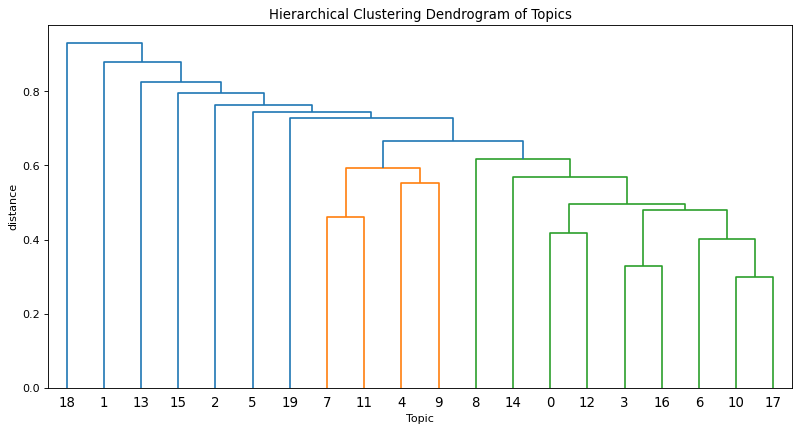

In [45]:
plt.figure(figsize=(12, 6), dpi=80)
plt.title('Hierarchical Clustering Dendrogram of Topics')
plt.xlabel('Topic')
plt.ylabel('distance')
dendrogram(
    Z
)
plt.show()

In [46]:
# write tables to csv
THETA.to_csv("./data/THETA.csv")
PHI.to_csv("./data/PHI.csv")
TOPIC.to_csv("./data/TOPIC.csv")

#### Genre Level Topics<a name=subparagraph7></a>
Topics at the corpus level seem to subdivide based on genre. In this section, I perform topic modeling on each genre separately. I hope that this will uncover different topics that reveal a latent structure in pieces of music journalism.

In [47]:
# create doc-term matrix for each genre
idx_country = LIB[LIB.topic == 'country'].index
idx_soul = LIB[LIB.topic == 'soul'].index

X_country = uBOW.loc[idx_country].n.unstack(fill_value=0)
X_country.columns = X_country.columns.astype(str)
X_country = X_country.drop('nan', axis=1)

# drop any terms that don't appear in country articles
X_country = X_country.loc[:, X_country.sum(axis=0)!=0]

# reduce to top 10000 terms by mean tfidf
top_country_terms = VOCAB.loc[X_country.columns]\
                         .sort_values('tfidf_mean', ascending=False)\
                         .head(10000)\
                         .index
X_country = X_country[top_country_terms]

# repeat for soul articles
X_soul = uBOW.loc[idx_soul].n.unstack(fill_value=0)
X_soul.columns = X_soul.columns.astype(str)
X_soul = X_soul.drop('nan', axis=1)
X_soul = X_soul.loc[:, X_soul.sum(axis=0)!=0]

top_soul_terms = VOCAB.loc[X_soul.columns]\
                         .sort_values('tfidf_mean', ascending=False)\
                         .head(10000)\
                         .index
X_soul = X_soul[top_soul_terms]

In [48]:
# country music topics
country_engine = LDA(n_components=10, max_iter=max_iter, learning_offset=offset, random_state=0)

# create THETA
THETA_country = pd.DataFrame(country_engine.fit_transform(X_country), index = X_country.index)
THETA_country.columns.name = 'topic_id'

# create PHI
PHI_country = pd.DataFrame(country_engine.components_, columns=X_country.columns)
PHI_country.index.name = 'topic_id'
PHI_country.columns.name  = 'term_str'
PHI_country = PHI_country.T

# create TOPIC table that identifies topic ids by top terms
TOPIC_country = PHI_country.sum().to_frame('phi_sum')

PHI_country_P = (PHI_country / PHI_country.sum())
PHI_country_I = np.log2(1/PHI_country_P)
TOPIC_country['h'] = round((PHI_country_I * PHI_country_P).sum().sort_values(ascending=False), 2)

n_top_terms = round(TOPIC_country.h.mean())

TOPIC_country['top_terms'] = PHI_country.T.apply(lambda x: ' '.join(x.sort_values(ascending=False).head(6).index), 1)

TOPIC_country['relevant_terms'] = get_relevant_terms(PHI_country, 6, 0)

In [49]:
# soul music topics
soul_engine = LDA(n_components=10, max_iter=max_iter, learning_offset=offset, random_state=0)

# create THETA
THETA_soul = pd.DataFrame(soul_engine.fit_transform(X_soul), index = X_soul.index)
THETA_soul.columns.name = 'topic_id'

# create PHI
PHI_soul = pd.DataFrame(soul_engine.components_, columns=X_soul.columns)
PHI_soul.index.name = 'topic_id'
PHI_soul.columns.name  = 'term_str'
PHI_soul = PHI_soul.T

# create TOPIC table that identifies topic ids by top terms
TOPIC_soul = PHI_soul.sum().to_frame('phi_sum')

PHI_soul_P = (PHI_soul / PHI_soul.sum())
PHI_soul_I = np.log2(1/PHI_soul_P)
TOPIC_soul['h'] = round((PHI_soul_I * PHI_soul_P).sum().sort_values(ascending=False), 2)

n_top_terms = round(TOPIC_soul.h.mean())

TOPIC_soul['top_terms'] = PHI_soul.T.apply(lambda x: ' '.join(x.sort_values(ascending=False).head(6).index), 1)

TOPIC_soul['relevant_terms'] = get_relevant_terms(PHI_soul, 6, 0)

In [50]:
#pd.concat([TOPIC_country, TOPIC_soul], axis=1)
TOPIC_soul[['top_terms', 'relevant_terms']]

top_terms  \
topic_id                                          
0                music band jazz album like new   
1              soul hit records new group album   
2              like just record people time got   
3                 like people just im dont time   
4             black prince like music album new   
5             time album song group record said   
6              soul music otis blues sam aretha   
7           soul love like album stage audience   
8         new orleans toussaint music like john   
9                 like just im people dont says   

                                             relevant_terms  
topic_id                                                     
0                 heron hancock nile herons worrell defunkt  
1                  drifters kerr berns sigma chimes dionnes  
2                       hp linx tinas graves castor verdine  
3               syreeta mt hardcastle jonzun colonel jasper  
4               dangelo winehouse aaliyah macy neneh alicia  
5               mavis cherrelle thelma hodges obrien pervis  
6                     jazzie gorrie bradley sar dowd ruffin  
7          ulmer lidell encores schmaltz vandrosss choruses  
8         toussaint meters neville dorsey rebennack nevi...  
9                    carey mariah monáe natalie lopez chaka

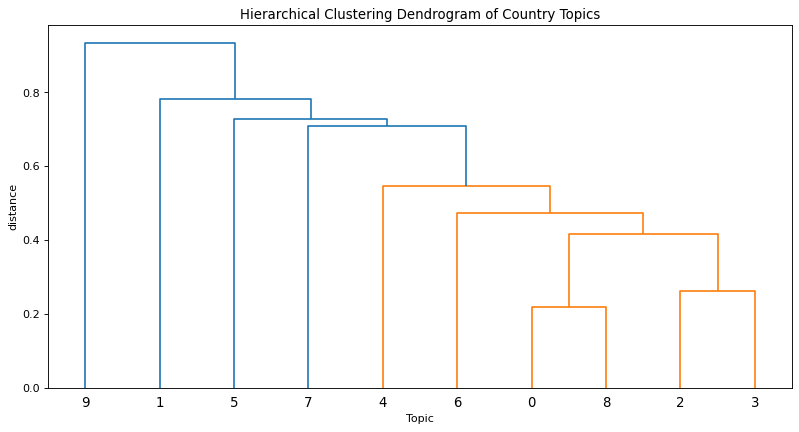

In [51]:
Z_country = linkage(PHI_country.T, 'weighted', 'cosine')

plt.figure(figsize=(12, 6), dpi=80)
plt.title('Hierarchical Clustering Dendrogram of Country Topics')
plt.xlabel('Topic')
plt.ylabel('distance')
dendrogram(
    Z_country
)
plt.show()

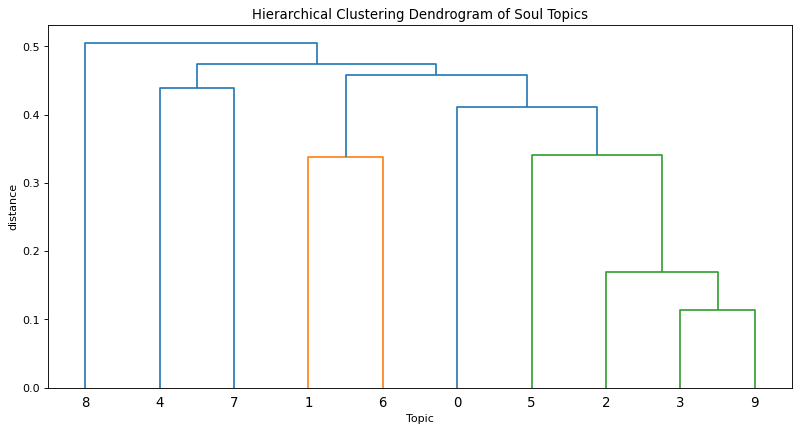

In [52]:
Z_soul = linkage(PHI_soul.T, 'weighted', 'cosine')

plt.figure(figsize=(12, 6), dpi=80)
plt.title('Hierarchical Clustering Dendrogram of Soul Topics')
plt.xlabel('Topic')
plt.ylabel('distance')
dendrogram(
    Z_soul
)
plt.show()

Topic modeling at the genre level does not reveal topics that are any more interesting than those at the corpus level. For each genre, the top terms are usually artist names and descriptors of the artists' style. For instance, **country topic 3** is identified by the relevant terms "kd", "langs", "singin", "liberal", "colored", and "contradiction". Clearly, this topic is about k.d. lang, and how her music might differ from the genre as a whole. (Maybe her music is "liberal" whereas the genre is conservative.)

Some topics are present at both the corpus and genre level. For example, **genre topic 8** and **soul topic 8** both seem to be about Dr. John, Allen Toussaint, The neville brothers, and New Orleans Funk.

What conclusions can be drawn from topic modeling on this corpus? Given the narrow focus of the corpus and uniformity of documents, it is unsurprising that topic modeling does not uncover wholly distinct topics. It's possible that initializing the algorithm with a smaller number of topics may find more disjoint groupings.

---
## Word Embeddings<a name="paragraph5"></a>

To create word embeddings, I use the gensim `word2vec` implementation.

In [53]:
from gensim.models import word2vec

# create dataframe of sentences
SENTENCE = CORPUS.groupby(['article_id', 'para_id', 'sent_id']) \
                 .term_str \
                 .apply(lambda  x:  x.tolist())

In [54]:
# set up W2V model
w2v_params = dict(
    min_count = 10,
    vector_size = 100,
    window = 4,
    seed = 10
)

w2v_model = word2vec.Word2Vec(SENTENCE.values, **w2v_params)

W2V = pd.DataFrame(w2v_model.wv.get_normed_vectors(), index=w2v_model.wv.index_to_key)
W2V.index.name = 'term_str'
W2V = W2V.sort_index()

In [55]:
tsne_params = dict(
    learning_rate = 200., #'auto' or [10.0, 1000.0]
    perplexity = 40,
    n_components = 2,
    init = 'random',
    n_iter = 800,
    random_state = 1    
)

tsne_engine = TSNE(**tsne_params)
tsne_model = tsne_engine.fit_transform(W2V)


In [56]:
COORDS = pd.DataFrame(tsne_model, columns=['x','y'], index=W2V.index)\
    .join(VOCAB, how='left')[['x','y','n','dfidf','max_pos_group','tfidf_mean']]

px.scatter(COORDS.reset_index(), 
           'x', 'y',
           title="t-SNE Clustering of Word2Vec Embedding",
           color='max_pos_group', 
           hover_name='term_str',          
           size='dfidf',           
           height=1000, width=1000).update_traces(
                mode='markers+text', 
                textfont=dict(color='black', size=14, family='Arial'),
                textposition='top center')

In [57]:
px.scatter(COORDS.reset_index().sort_values('dfidf', ascending=False).head(2000), 
           'x', 'y',
           title="t-SNE Clustering of Word2Vec Embedding, Top 2000 Terms",
           color='max_pos_group',
           hover_name='term_str',
           size='dfidf',
           height=1000, width=1000) \
  .update_traces(mode='markers+text',
                 textfont=dict(color='black', size=14, family='Arial'),
                 textposition='bottom left')

The two t-SNE plots above use the word embeddings to cluster semantically similar terms. The first plot shows all terms in the corpus. The second plot isolates just the top 2000 terms by *dfidf*. Terms cluster with similar parts of speech. For instance, proper nouns cluster at the top of the image. Verbs are scattered to the bottom. Regular nouns group to the left.

Next, I test Dr. Rafael Alvarado's analogy methods. These methods, `complete_analogy` and `get_most_similar`, perform semantic algebra operations on provided terms. Given terms *A*, *B*,  and *C*,`complete_analogy` returns the term *D* that best satifies the analogy *A:B::C:D*. `get_most_similar` returns a list of the most similar terms to a provided term.

In [58]:
def complete_analogy(A, B, C, n=2):
    try:
        cols = ['term', 'sim']
        return pd.DataFrame(w2v_model.wv.most_similar(positive=[B, C], negative=[A])[0:n], columns=cols)
    except KeyError as e:
        print('Error:', e)
        return None
    
def get_most_similar(positive, negative=None):
    return pd.DataFrame(w2v_model.wv.most_similar(positive, negative), columns=['term', 'sim'])

In [59]:
complete_analogy("country", "banjo", "soul", n=5)

term       sim
0       sax  0.707460
1     pedal  0.697810
2  mandolin  0.691299
3  trombone  0.687786
4     flute  0.683961

In [60]:
get_most_similar("supremes")
#get_most_similar("guitar", "country")

term       sim
0  temptations  0.850139
1     miracles  0.809280
2      beatles  0.764907
3     spinners  0.746287
4        byrds  0.724158
5        temps  0.717503
6       isleys  0.715744
7         pips  0.713078
8     drifters  0.706761
9   stylistics  0.690528

In [61]:
W2V.to_csv("./data/W2V.csv")

---
## Sentiment Analysis<a name="paragraph6"></a>

I assess the sentiment of the corpus using the NRC and VADER lexicons. The NRC lexicon will allow me to measure emotion as well as sentiment. The VADER lexicon was developed to measure sentiment in social media. I hypothesize that music reviews are similar in structure to product reviews on social media sites like Yelp and Facebook, and thus VADER might be well suited to this corpus.

#### NRC Lexicon<a name=subparagraph8></a>
I use the NRC lexicon to investigate emotion within the corpus.

In [62]:
# import lexicons

# NRC valence-arousal-dominance
NRC_VAD = pd.read_csv(path+"NRC-VAD-Lexicon/NRC-VAD-Lexicon.txt", \
                      header = None, sep="\t", \
                      names = ['term_str', 'valence', 'arousal', 'dominance'])
NRC_VAD = NRC_VAD.set_index('term_str')
NRC_VAD.columns = ['nrc_'+col for col in NRC_VAD.columns]

# NRC emotion
NRC_EMO = pd.read_csv(path+"NRC-Emotion-Lexicon-v0.92/NRC-Emotion-Lexicon-Wordlevel-v0.92.txt", \
                      header = None, sep="\t", \
                      names = ['term_str', 'emotion', 'level'])
NRC_EMO = NRC_EMO.set_index(['term_str', 'emotion']).unstack()
NRC_EMO.columns = NRC_EMO.columns.droplevel(0)
NRC_EMO = NRC_EMO[NRC_EMO.sum(1) > 0]
NRC_EMO = NRC_EMO[['anger', 'anticipation', 'disgust', 'fear', 'joy', 
                   'sadness', 'surprise', 'trust', 'positive', 'negative']]
NRC_EMO.columns = ['nrc_'+col for col in NRC_EMO.columns]

I attach the NRC values to the `VOCAB` table. Then, I compute average emotion, sentiment, and VAD values for each document in the corpus.

In [63]:
# join lexicons to VOCAB
VOCAB2 = VOCAB.join(NRC_VAD, how='left').join(NRC_EMO, how='left')

In [64]:
# compute mean of each NRC attribute for each article
nrc_cols = [x for x in VOCAB2 if 'nrc' in x]

MEAN_NRC = CORPUS.join(NRC_EMO, on='term_str').join(NRC_VAD, on='term_str')
MEAN_NRC = MEAN_NRC[nrc_cols].groupby('article_id').mean()

# join with LIB
LIB2 = LIB.join(MEAN_NRC)

In [65]:
# Visualize article sentiment
from plotly.subplots import make_subplots
import plotly.graph_objects as go

px.scatter_3d(LIB2,
              'nrc_valence', 'nrc_arousal', 'nrc_dominance',
              title = 'Valence, Arousal, and Dominance of Music Journalism',
              color = 'topic',
              hover_name='label',
              height=1000, width=1000)\
  .update_traces(marker={'size': 5, 'line': {'width':2, 'color':'white'}})

The image above, plots each article in valence-arousal-dominance space. Points are colored by genre. There seems to be positive correlation between dominance and arousal and dominance and valence. There is a negative correlation between valence and arousal. This is made more explicit in the subplots, below. The inverse relationship between valence and arousal suggests that negative words (low valence) are more intense (high arousal)--at least in this corpus. Words that are positive (high valence) and words that are energetic (high arousal) are likely to be dominant.

In [66]:
#visualize VAD in 2D
fig = make_subplots(rows=1, cols=3)

fig1 = px.scatter(LIB2, 'nrc_valence', 'nrc_arousal',trendline='ols',trendline_color_override="navy")
fig2 = px.scatter(LIB2, 'nrc_arousal', 'nrc_dominance',trendline='ols',trendline_color_override="navy")
fig3 = px.scatter(LIB2, 'nrc_dominance', 'nrc_valence',trendline='ols',trendline_color_override="navy")

figs = [fig1, fig2, fig3]
i=0
for f in figs:
    i+=1
    for d in f.data:
        fig.add_trace(
            d,
            row=1,
            col=i
        )

fig['layout']['xaxis']['title']='valence'
fig['layout']['xaxis2']['title']='arousal'
fig['layout']['xaxis3']['title']='dominance'
fig['layout']['yaxis']['title']='arousal'
fig['layout']['yaxis2']['title']='dominance'
fig['layout']['yaxis3']['title']='valence'

fig.update_layout(height=400, width=1000, title_text="Correlation in Valence, Arousal, Dominance") \
   .update_traces(marker={'size':5, 'line': {'width':0.5, 'color':'white'}})
fig.show()

C:\Users\brook\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

C:\Users\brook\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning:

pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.



In [67]:
emo_cols = ['nrc_anger','nrc_anticipation', 'nrc_disgust', 'nrc_fear', 
            'nrc_joy', 'nrc_sadness', 'nrc_surprise', 'nrc_trust']
px.bar(LIB2.reset_index().sample(8, random_state=33), emo_cols, 'label', 
       orientation='h', title = 'Emotional Sentiment in Sampled Articles', height=800)

In [68]:
document_type_pol = LIB2.groupby('type')[['nrc_positive', 'nrc_negative']].mean()
document_type_pol['nrc_negative']=-1*document_type_pol['nrc_negative']
document_type_pol['nrc_polarity']=document_type_pol.nrc_positive+document_type_pol.nrc_negative

px.bar(document_type_pol.reset_index().sort_values('nrc_polarity'), ['nrc_positive', 'nrc_negative'], 'type', 
       orientation='h', title = 'Positive and Negative Sentiment by document type', height=800)

The stacked bar chart above displays a sample of 8 articles and their average NRC emotion values. Anticipation, Joy, and Trust seem to be the most prevalent emotions. There are likely a lot of anticipation-related words since music journalism often discusses forthcoming albums and shows.

The second stacked bar chart shows article types. The chart is sorted by polarity so that the article types at the top are more positive and the types at the bottom are more negative. Profiles and interviews are more positive than reviews which are more positive that reports and essays. 

In [69]:
LIB2_COORDS = LIB2
LIB2_COORDS['valence'] = LIB2.rolling(100, center=True).nrc_valence.mean()
px.line(LIB2_COORDS,
       'date', 'valence', height = 300, width =600)

In [70]:
LIB2[['date','title']+emo_cols].sample(10, random_state=84) \
                               .style \
                               .background_gradient(cmap='inferno',
                                                    vmin=LIB2[emo_cols].min().min(), \
                                                    vmax=LIB2[emo_cols].max().max())

#### VADER Analysis<a name=subparagraph9></a>
The VADER sentiment intensity analyzer is applied to sentences.

In [71]:
#VADER
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

analyzer = SentimentIntensityAnalyzer()

vader_cols = [f"vader_{col}" for col in "neg neu pos compound".split()]

SENTENCE = SENTENCE.to_frame().rename(columns={'term_str':'sent_str'})
SENTENCE['sent_str'] = [' '.join(map(str, x)) for x in SENTENCE.sent_str]
SENTENCE[vader_cols] = SENTENCE.sent_str.apply(analyzer.polarity_scores).apply(lambda x: pd.Series(x))
SENTENCE.sample(10, random_state=4) \
        .style \
        .background_gradient(cmap = 'RdYlGn', \
                             subset='vader_compound', \
                             vmin=SENTENCE.vader_compound.min(), \
                             vmax=SENTENCE.vader_compound.max())

I sample some sentences that have been tagged using the VADER `SentimentIntensityAnalyzer`. The neg, neu, and pos columns are the proportions of negative, neutral, and positive terms in the sentence, respectively. The compound column captures sentiment with a single, weighted and normalized statistic. The sample above shows that VADER does a pretty good job, but it's not perfect. It does well to mark sentence [s14019, 6, 1] as very negative, but it misclassifies sentence [s7308, 68, 1] as neutral.

I aggregate the VADER sentiment statistics for each article. Then I analyze sentiment scores across genre and article type.

In [72]:
MEAN_VADER = SENTENCE.groupby('article_id').mean()
MEAN_VADER = MEAN_VADER.join(LIB, how='left')[vader_cols+ ['topic', 'type', 'label']]
MEAN_VADER = MEAN_VADER[MEAN_VADER['type'].map(MEAN_VADER['type'].value_counts()) > 20]

MEAN_VADER.sample(8, random_state=11) \
        .style \
        .background_gradient(cmap = 'RdYlGn', \
                             subset='vader_compound', \
                             vmin=MEAN_VADER.vader_compound.min(), \
                             vmax=MEAN_VADER.vader_compound.max())


In [73]:
px.bar(MEAN_VADER.groupby(['topic', 'type']).mean().reset_index().sort_values('vader_compound'), \
       ['vader_compound'], 'type', \
       color = 'topic', \
       title = 'Mean VADER Compound Values of Article Types', \
       barmode='group',
       width = 600).update_layout(legend=dict(orientation="h"))

The results of VADER sentiment analyis are quite similar to the NRC analysis despite the differences in methodology. This may be due to the aggregating the sentiments of multiple articles under a single article type. In this way, the extreme sentiments of any given article are smoothed over. The average sentiment appears as neutral to slightly positive.

---

In [74]:
# write LIB2 and VOCAB2
LIB2.to_csv(path+"LIB2.csv")
VOCAB2.to_csv(path+"VOCAB2.csv")